In [4]:
# import libraries
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt

import tqdm

from typing import Sequence, Tuple, Optional, List

# Import and Process Data

In [2]:
nImages = 2000
imgSize = 30

# initialize tensor containing images
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages,1)

for i in range(nImages):

  # and add noise
  G  = np.random.randn(imgSize,imgSize)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1 # horizontal
  else:
    G[:,i1:i1+i2] = 1 # vertical
    labels[i] = 1

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

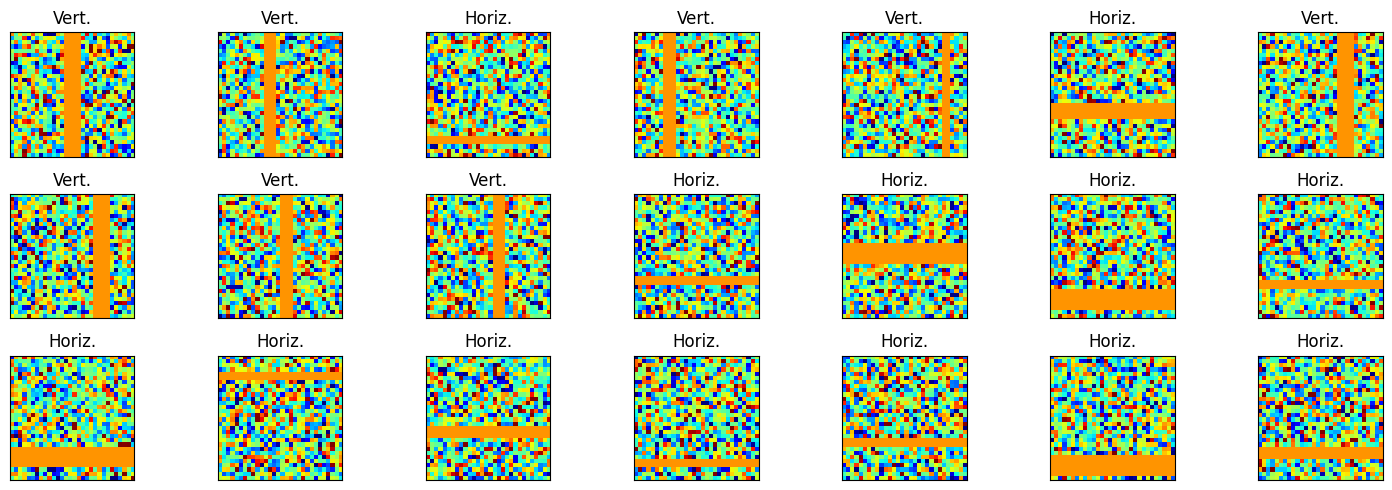

In [3]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-2,vmax=2,cmap='jet',extent=[-4,4,-4,4],origin='upper')

  title = 'Horiz.' if labels[whichpic].item()==0 else 'Vert.'
  ax.set_title(title)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show();

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
# check size (should be images X channels X width X height
train_loader.dataset.tensors[0].shape

torch.Size([1800, 1, 30, 30])

# Create DL model

In [7]:
# Helper functions

def _as_list(value, n: int):
    """Normalize a scalar/tuple/sequence into a list of length n.
       - If value is a scalar or tuple, replicate it n times.
       - If value is a sequence of length 1, replicate it n times.
       - If value is a sequence of length n, use as is.
    """

    # tuples are valid for kernel/stride/padding/dilation
    if isinstance(value, (int, float, tuple)):
        return [value for _ in range(n)]
    if isinstance(value, Sequence):
        if len(value) == 1 and n > 1:
            return [value[0] for _ in range(n)]
        if len(value) == n:
            return list(value)
    raise ValueError(f"Could not broadcast parameter to length {n}: {value}")

In [25]:
# create a class for the model

def makeTheNet(out_channels: Sequence[int] = [6,6],         #conv1, conv2
                kernel_size: int | Tuple[int, int]=3,
                stride: int | Tuple[int, int]=1,
                padding: Optional[int | Tuple[int, int]]=[1,0],
                pool_size: Optional[Tuple[int, int]]=(2,2),
                dilation: int | Tuple[int, int]=1,
                groups: int =1,
                bias: bool =True,
                padding_mode: str='zeros',
                cv_dropout: float = 0.0,
                cv_batchnorm: bool = False,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = [50],
                ln_batchnorm: bool = False,
                out_size: int = 26,
                ln_dropout: float = 0.0,

                # Regularization
                optimizer = 'Adam',
                weight_decay: float = 0.0,
                lr: float = 1e-3,

                device=None,
                dtype=None,
                printtoggle: bool = False):

  class cnnNet(nn.Module):
    def __init__(self,
                out_channels: Sequence[int] = out_channels,     #conv1, conv2
                kernel_size: int | Tuple[int, int]=kernel_size,
                stride: int | Tuple[int, int]=stride,
                padding: Optional[int | Tuple[int, int]]=padding,
                pool_size: Optional[Tuple[int, int]]=pool_size,
                dilation: int | Tuple[int, int]=dilation,
                groups: int =groups,
                bias: bool = bias,
                padding_mode: str=padding_mode,
                cv_dropout: float = cv_dropout,
                cv_batchnorm: bool = cv_batchnorm,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = uLinear,
                ln_batchnorm: bool = ln_batchnorm,
                out_size: int = out_size,
                ln_dropout: float = ln_dropout,
                device=device,
                dtype=dtype,
                printtoggle: bool = printtoggle
                ):
      super().__init__()

      for i, oc in enumerate(out_channels):
          assert int(oc) > 0, f"out_channels[{i}] must be > 0, got {oc}"


      # print toggle
      self.printtoggle = printtoggle

      self.pool = nn.MaxPool2d(pool_size)

      self.cv_batchnorm = cv_batchnorm
      self.ln_batchnorm = ln_batchnorm


      nBlocks = len(out_channels)               # number of conv blocks

      # Normalize per-block parameters
      k_list = _as_list(kernel_size, nBlocks)
      s_list = _as_list(stride,      nBlocks)
      p_list = _as_list(padding,     nBlocks)
      d_list = _as_list(dilation,    nBlocks)
      pool_list = _as_list(pool_size, nBlocks)

      #--------Build Convoluation Blocks----------
      convs = []
      cbns = []                 # Batch normalization for each layer
      pools = []
      cdo = []                 # Dropout per convolution block (optional)


      # ---- Convolutional stack ----
      for i in range(nBlocks):
        convs.append(nn.LazyConv2d(
        out_channels=out_channels[i],
        kernel_size=k_list[i],
        stride=s_list[i],
        padding=p_list[i],
        dilation=d_list[i],
        groups=groups,
        bias=bias,
        padding_mode=padding_mode
    ))

        if self.cv_batchnorm:
          cbns.append(nn.BatchNorm2d(out_channels[i]))
        else:
          cbns.append(nn.Identity())

        pools.append(nn.MaxPool2d(kernel_size=pool_list[i]))

        if cv_dropout > 0:
          cdo.append(nn.Dropout2d(cv_dropout))
        else:
          cdo.append(nn.Identity())

      self.convs = nn.ModuleList(convs)
      self.cbns  = nn.ModuleList(cbns)
      self.pools = nn.ModuleList(pools)
      self.cdo   = nn.ModuleList(cdo)

      # Safety checks (helps catch the “zip returns nothing” bug)
      assert len(self.convs) > 0, "No conv blocks built"
      assert len(self.convs) == len(self.pools) == len(self.cbns) == len(self.cdo), (len(self.convs), len(self.pools), len(self.cbns), len(self.cdo))

      # --- Linear stack/ Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]
      fcs, fbns, fdo = [], [], []

      for h in sizes:
          fcs.append(nn.LazyLinear(h))
          if self.ln_batchnorm:
            fbns.append(nn.BatchNorm1d(h))
          else:
            fbns.append(nn.Identity())

          if ln_dropout > 0:
              fdo.append(nn.Dropout(ln_dropout))
          else:
              fdo.append(nn.Identity())


      self.fcs  = nn.ModuleList(fcs)
      self.fbns = nn.ModuleList(fbns)
      self.fdo  = nn.ModuleList(fdo)
      self.output_layer = nn.LazyLinear(out_size)

    def forward(self,x):

      if self.printtoggle: print(f'Input: {list(x.shape)}')

      # Convolutional stack: Conv -> (BN) -> Max_Pool -> LeakyReLU -> (Dropout2d)
      for i in range(len(self.convs)):

        x = self.convs[i](x)
        x = self.cbns[i](x)
        x = self.pools[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.cdo[i](x)

        if self.printtoggle: print(f'After block {i+1}: {list(x.shape)}')
        if self.printtoggle: print(f'Block {i+1} padding {self.convs[i].padding}')

      # reshape for linear layer
      x = torch.flatten(x,start_dim=1)
      if self.printtoggle: print(f'Vectorized: {list(x.shape)}')

      ## FC stack
      for i in range(len(self.fcs)):

        x = self.fcs[i](x)
        x = self.fbns[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.fdo[i](x)

        if self.printtoggle: print(f'After FC {i+1}: {list(x.shape)}')


      x = self.output_layer(x)

      return x

  #-------------------End of model factory------------------------------

  # create the model instance
  net = cnnNet()

  # Move to device/dtype once (constructor kwargs are version-fragile)
  if device is not None or dtype is not None:
      net = net.to(device=device, dtype=dtype)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = getattr(torch.optim,optimizer)(net.parameters(),lr=lr,weight_decay=weight_decay)

  return net,lossfun,optimizer

In [26]:
# test the model with one batch
out_channels = [5,10]
uLinear = [15]
paddings = [1,1]
out_size = 1
printtoggle = True

net,lossfun,optimizer = makeTheNet(out_size = out_size,
                                   out_channels = out_channels,
                                   uLinear = uLinear,
                                   padding = paddings,
                                   printtoggle=printtoggle
                                )

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y).detach().numpy()
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 30, 30]
After block 1: [32, 5, 15, 15]
Block 1 padding (1, 1)
After block 2: [32, 10, 7, 7]
Block 2 padding (1, 1)
Vectorized: [32, 490]
After FC 1: [32, 15]

Output size:
torch.Size([32, 1])
 
Loss:
0.7554767


# Create a function to train the model

In [35]:
def function2trainTheModel(
    numepochs: int,
    test_dataset: DataLoader,
    *,
    out_channels: list[int] = [6, 6],
    kernel_size: int | tuple[int, int] = 3,
    stride: int | tuple[int, int] = 1,
    padding: int | tuple[int, int] | list[tuple[int, int]] = [1, 0, 0],
    pool_size: tuple[int, int] = (2, 2),
    dilation: int | tuple[int, int] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = "zeros",
    cv_dropout: float = 0.0,
    cv_batchnorm: bool = False,
    uLinear: list[int] = [50],
    ln_batchnorm: bool = False,
    out_size: int = 26,
    ln_dropout: float = 0.0,
    optimizer: str = "Adam",          # name of optimizer (Adam, AdamW, SGD, ...)
    weight_decay: float = 0.0,
    lr: float = 1e-3,
    device: torch.device | None = None,
    dtype=None,
    printtoggle: bool = False,
):
    # ---------- Device selection (don’t rely on outer globals) ----------
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    print("Using device:", device)

    opt_name = optimizer

    net, lossfun, opt = makeTheNet(
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        pool_size=pool_size,
        dilation=dilation,
        groups=groups,
        bias=bias,
        padding_mode=padding_mode,
        cv_dropout=cv_dropout,
        cv_batchnorm=cv_batchnorm,
        uLinear=uLinear,
        ln_batchnorm=ln_batchnorm,
        out_size=out_size,
        ln_dropout=ln_dropout,
        optimizer=opt_name,
        weight_decay=weight_decay,
        lr=lr,
        device=device,   # safely pass device through
        dtype=dtype,
        printtoggle=printtoggle,
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    opt = optimizer

    net.to(device)
    lossfun = lossfun.to(device)

    # ---------- AMP (new API); enable only on CUDA ----------
    use_cuda = (device.type == "cuda")
    scaler = torch.amp.GradScaler(enabled=use_cuda)
    autocast_ctx = torch.autocast(device_type="cuda",dtype=torch.float16, enabled=use_cuda)

    # ---------- Metrics (avoid per-batch .item() → sync once/epoch) ----------
    trainLoss = np.zeros(numepochs)
    testLoss  = np.zeros(numepochs)
    trainAcc  = np.zeros(numepochs)
    testAcc   = np.zeros(numepochs)


    # ---------- Epoch loop ----------
    # for epochi in tqdm(range(numepochs), desc="Epoch", total=numepochs):
    for epochi in range(numepochs):

      net.train()
        # ---------- Batch loop ----------
      batchloss = []
      batchacc = []

        # for X, y in tqdm(train_loader, desc="Batch", total=len(train_loader.dataset.data)/batch_size,leave=False):
      for X, y in train_loader:
          X = X.to(device, non_blocking=True)
          y = y.to(device, non_blocking=True)

          opt.zero_grad(set_to_none=True)

          with autocast_ctx:
              yHat = net(X)
              loss = lossfun(yHat, y)

          if use_cuda:
              scaler.scale(loss).backward()
              scaler.step(opt)
              scaler.update()
          else:
              loss.backward()
              opt.step()

          # accumulate on device (no CPU sync)
          with torch.no_grad():
              batchloss.append(loss.detach().cpu().numpy())

              # Accuracy
              ySig = torch.sigmoid(yHat).detach().cpu()

              yPred = (ySig > 0.5).float()
              acc = (yPred == y).float()
              batchacc.append(100 * torch.mean(acc))


      # end train epoch: sync once
      trainLoss[epochi] = np.mean(batchloss)
      trainAcc[epochi]  = np.mean(batchacc)

        # -------Evaluation on full test loader (not a single batch) ----------
      net.eval()
      batchloss = []
      batchacc = []

      with torch.no_grad():
          for X, y in test_dataset:
              X = X.to(device, non_blocking=True)
              y = y.to(device, non_blocking=True)
              yHat = net(X)

              loss = lossfun(yHat, y)
              batchloss.append(loss.detach().cpu().numpy())

              #Accuracy
              ySig = torch.sigmoid(yHat).detach().cpu()

              yPred = (ySig > 0.5).float()
              acc = (yPred == y).float()
              batchacc.append(100 * torch.mean(acc))

      testLoss[epochi] = np.mean(batchloss)
      testAcc[epochi]  = np.mean(batchacc)

    # done
    return trainLoss, testLoss, trainAcc, testAcc, net


# Run the model

In [36]:
numepochs = 100
test_dataset = test_loader
out_channels = [5,10]
uLinear = [15]
paddings = [1,1]
out_size = 1
printtoggle = False

trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel(
    numepochs,
    test_dataset,
    out_size = out_size,
    out_channels = out_channels,
    uLinear = uLinear,
    padding = paddings,
    printtoggle=printtoggle
)

Using device: cpu


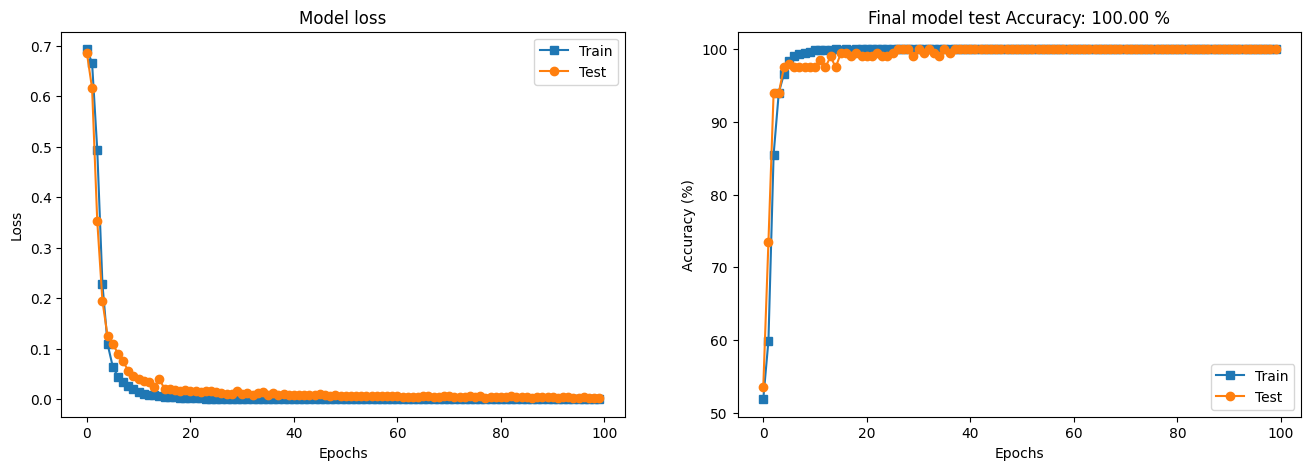

In [40]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test Accuracy: {testAcc[-1]:.2f} %')
ax[1].legend()

plt.show();

# Create the Images

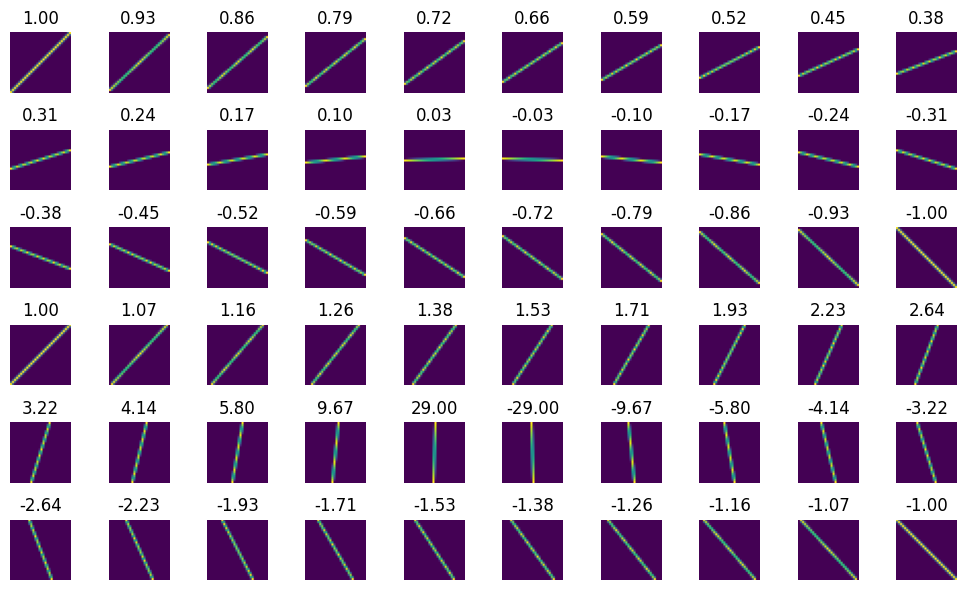

In [41]:
### create lines in images

from skimage.draw import line_aa

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')


  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show();

In [49]:
np.squeeze(yHat_np).shape

(60,)

/tmp/ipython-input-3854856325.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = float(yHat_np[i])


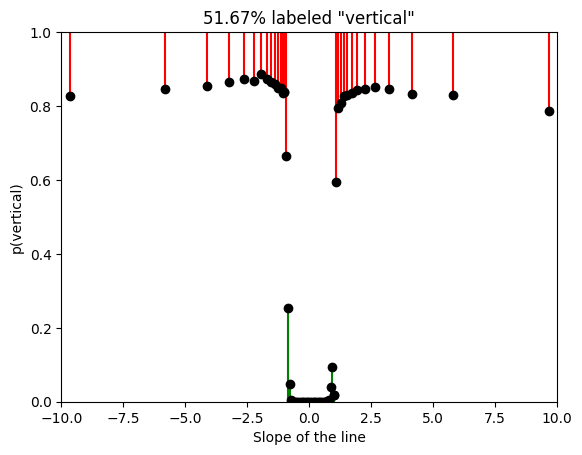

In [52]:
# run the images through the model

# randomly shuffle the images and convert to tensor

ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx,:,:,:].astype(np.float32))


# now generate the prediction (horizontal or vertical)
net.eval()
yHat = torch.sigmoid( net(imgT) ).detach()

# Convert yHat to a NumPy array
yHat_np = yHat.numpy()

# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  x = float(slopes[ridx[i]])
  y = float(yHat_np[i])

  if yHat_np[i]>.5:
    plt.plot([x,x],[1,y],'r')
  else:
    plt.plot([x,x],[0,y],'g')

plt.plot(slopes[ridx],yHat_np,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()

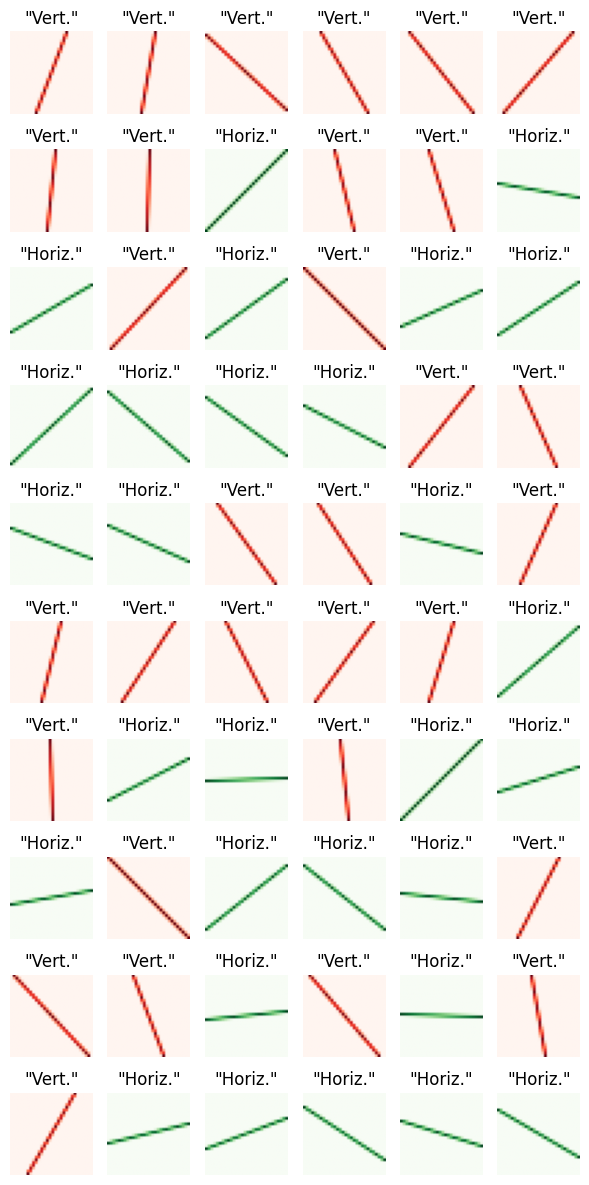

In [51]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):

  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Reds')
  else:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Greens')

  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show();